# An introduction to overfitting

In the previous lab we have designed and trained an MLP network for image classification. We relied on a rather naive approach, which in practice is a bit risky. Indeed, our model was designed and trained for minimizing the loss on the training set, so we might end up with a model which is very good at predicting the data from this training set. However, it might be unable to generalize to unseen/new data (e.g., from the test set). This behavior is called **overfitting** and is a major problem in deep learning, wich we adress in this script.

<center><a href="https://medium.com/geekculture/investigating-underfitting-and-overfitting-70382835e45c">
    <img src="https://miro.medium.com/max/1400/1*OeJVQ7sEvOJGxfGSCpbzyA.png" width="600"></a></center>

In [1]:
import torch 
import torchvision
import torch.nn as nn
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import DataLoader, random_split, Subset
import copy

## Dataset and model

As in the previous lab, we work with the MNIST dataset and we use a simple 3-layer MLP. We provide the code below.

In [2]:
os.chdir('/mnt/c/Master2/DeepLearning/lab4')

In [3]:
# Define the data repository
data_dir = 'data/'

# Load the MNIST dataset
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)

# Take a subset of the train/test data
train_data = Subset(train_data, torch.arange(400))
test_data = Subset(test_data, torch.arange(50))

# Create the dataloaders
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [4]:
class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super(MLPClassif, self).__init__()
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), act_fn)
        self.hidden_layer = nn.Sequential(nn.Linear(hidden_size, hidden_size), act_fn)
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        y = self.input_layer(x)
        y = self.hidden_layer(y)
        out = self.output_layer(y)
        return out

In [16]:
# Instanciate the network and initialize the parameters for reproducibility
input_size = train_data[0][0][0].shape[0]*train_data[0][0][0].shape[1]
hidden_size = 10
act_fn = nn.ReLU()
output_size = num_classes
model = MLPClassif(input_size, hidden_size, output_size, act_fn)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        m.bias.data.fill_(0.01)

torch.manual_seed(0)
model.apply(init_weights)

MLPClassif(
  (input_layer): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
  )
  (hidden_layer): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (output_layer): Linear(in_features=10, out_features=10, bias=True)
)

## Training with validation: early stopping

There are many strategies to avoid overfitting, but a first simple approach is to monitor the performance of the model (when training) on another subset called the *validation* (or *development*) set. At each epoch we compute the loss on the validation set, and check how it behaves: if the validation loss decreases, then we can continue training. Conversely, if the validation loss increases, it means the model has overfitted, so we need to stop training. In practice, we run training with a specified maximum number of epochs, and we save the model which yields the lowest validation loss. This strategy is called *early stopping*.

<center><a href="https://bioinfo.iric.ca/fr/le-surapprentissage-et-la-regularisation/">
    <img src="https://bioinfo.iric.ca/wpbioinfo/wp-content/uploads/2017/10/error_curves-400x400.png" width="300"></a></center>

On the example above, the blue curve is the training loss (which keeps decreasing), and the red curve is the validation loss. The dashed line indicates the best model we can get (lowest validation loss).

**Note**: instead of computing the validation loss (which ideally should decrease), we can compute the validation accuracy (which ideally should increase). The concept is the same, but in practice it's better to use a validation metric that is as close as possible or equal to the test metric (here: accuracy).

In [17]:
# First we define the validation set by splitting the training data into 2 subsets (90% training and 10% validation)
n_train_examples = int(len(train_data)*0.9)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples])

# We also define the corresponding dataloaders
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size)

In [18]:
x, y = next(iter(train_dataloader))
print(x.shape, y.shape)

torch.Size([8, 1, 28, 28]) torch.Size([8])


In [19]:
# Evaluation function: similar to the training loop, except we don't need to compute any gradient / backprop
def eval_mlp_classifier(model, eval_dataloader):
    
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels
            images = images.reshape(images.shape[0], -1)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [20]:
# TO DO: write the training function with validation
# - the overall training procedure is similar to what was done in lab 3 (reuse it)
# - at the end of each epoch, compute the accuracy of the model on the validation subset using the provided evaluation function
# - then, check if this accuracy is increasing: if so, then we save the current model as the 'model_opt'.
# - return as output the trained model, the training loss, and the validation accuracy

def training_mlp_classifier(model, train_dataloader,eval_dataloader, num_epochs, loss_fn, learning_rate, verbose=True):
 
   # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    
    # Set the model in 'training' mode (ensures all parameters' gradients are computed - it's like setting 'requires_grad=True' for all parameters)
    model_tr.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model_tr.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    val_accuracy = []
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (size should be (batch_size, input_size))
            # - apply the forward pass (calculate the predicted labels from the vectorized images)
            # - use the 'backward' method to compute the gradients
            # - apply the gradient descent algorithm
            # Also think of updating the loss at the current epoch
            y_pred = model_tr(images.view(-1, 784))
            l = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            l.backward()
            loss_current_epoch += l.item()
            optimizer.step() #update parameters

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        accuracy = eval_mlp_classifier(model_tr, eval_dataloader)
        val_accuracy.append(accuracy)
        if verbose and ((epoch+1)%5==0):
            print('Epoch [{}/{}], Loss: {:.4f}, validation accuracy : {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch, accuracy))
        
    return model_tr, loss_all_epochs, val_accuracy

In [21]:
# TO DO:
# - Train the model with validation (Cross Entropy loss, 30 epochs, learning rate = 0.01)
# - Plot the (training) loss and (validation) accuracy over epochs
lr = 0.01
num_epochs = 30
loss_fn = nn.CrossEntropyLoss()
history = training_mlp_classifier(model, train_dataloader,test_dataloader, num_epochs, loss_fn, lr, verbose=True)

Epoch [5/30], Loss: 45.7650, validation accuracy : 64.0000
Epoch [10/30], Loss: 14.0263, validation accuracy : 80.0000
Epoch [15/30], Loss: 6.7068, validation accuracy : 84.0000
Epoch [20/30], Loss: 3.6639, validation accuracy : 72.0000
Epoch [25/30], Loss: 2.2553, validation accuracy : 78.0000
Epoch [30/30], Loss: 1.5497, validation accuracy : 72.0000


<span style="color:red">**Q1**</span> Put the plot above (training loss and validation accuracy) in your report. What do you remark? Is it beneficial to do early stopping?

## Adjusting the model's capacity

The number of layers in the network is expected to have a major impact on performance (accuracy). Too few parameters might yield bad performance (underfitting), while too many might lead to overfitting. Therefore, we can train and test several networks, where we change the number of hidden layers.

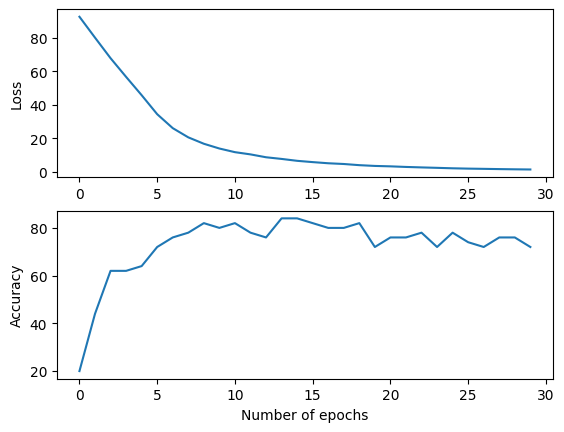

In [22]:
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)
ax1.plot(range(30), history[1])
ax1.set_ylabel("Loss")
ax2.plot(range(30), history[2])
ax2.set_xlabel("Number of epochs")
ax2.set_ylabel("Accuracy")
ax1.get_shared_x_axes().join(ax1, ax2)
plt.show()

In [23]:
# TO DO: write the MLP classifier ('__init__' and 'forward' methods) with a variable number of hidden layers.
# hint: you can create list of layers using the 'torch.nn.ModuleList' function (and a 'for' loop).
# More info at: https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, act_fn):
        super(MLPClassifier, self).__init__()
        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), act_fn)
        self.linears = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_layers)])
        self.output_layer = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.input_layer(x)
        for layer in self.linears:
            x = act_fn(layer(x))
        x = self.output_layer(x)
        return x

In [24]:
model2 = MLPClassifier(784, 10, 10, 10, act_fn)
model2.apply(init_weights)

MLPClassifier(
  (input_layer): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
  )
  (linears): ModuleList(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): Linear(in_features=10, out_features=10, bias=True)
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): Linear(in_features=10, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=10, bias=True)
)

In [25]:
# TO DO:
# - Define the general parameters of the MLP classifier model and training (same as before)
# - Train and evaluate the model for a variable number of hidden layers (ranging in [0, 1, 2])
# - Plot the test accuracy as a function of the number of hidden layers
total_accuracy = []
for hidden_layer in range(3):
    print(f"Number of hidden layers : {hidden_layer}")
    model = MLPClassifier(784, 10, 10, hidden_layer, act_fn)
    model.apply(init_weights)
    history = training_mlp_classifier(model, train_dataloader,test_dataloader,
                                   num_epochs, loss_fn, lr, verbose=True)
    total_accuracy.append(max(history[2]))

Number of hidden layers : 0
Epoch [5/30], Loss: 31.4156, validation accuracy : 72.0000
Epoch [10/30], Loss: 12.2735, validation accuracy : 86.0000
Epoch [15/30], Loss: 6.5727, validation accuracy : 86.0000
Epoch [20/30], Loss: 4.0822, validation accuracy : 86.0000
Epoch [25/30], Loss: 2.8847, validation accuracy : 90.0000
Epoch [30/30], Loss: 2.1339, validation accuracy : 90.0000
Number of hidden layers : 1
Epoch [5/30], Loss: 41.7225, validation accuracy : 68.0000
Epoch [10/30], Loss: 15.6113, validation accuracy : 80.0000
Epoch [15/30], Loss: 7.1105, validation accuracy : 80.0000
Epoch [20/30], Loss: 3.5817, validation accuracy : 78.0000
Epoch [25/30], Loss: 2.1347, validation accuracy : 78.0000
Epoch [30/30], Loss: 1.4898, validation accuracy : 80.0000
Number of hidden layers : 2
Epoch [5/30], Loss: 59.0346, validation accuracy : 50.0000
Epoch [10/30], Loss: 30.9166, validation accuracy : 66.0000
Epoch [15/30], Loss: 15.9984, validation accuracy : 66.0000
Epoch [20/30], Loss: 9.1923

<span style="color:red">**Q2**</span> Put the plot above (test accuracy as a function of number of hidden layers) in your report. What do you observe? What's the best model to use?

Text(0, 0.5, 'Accuracy')

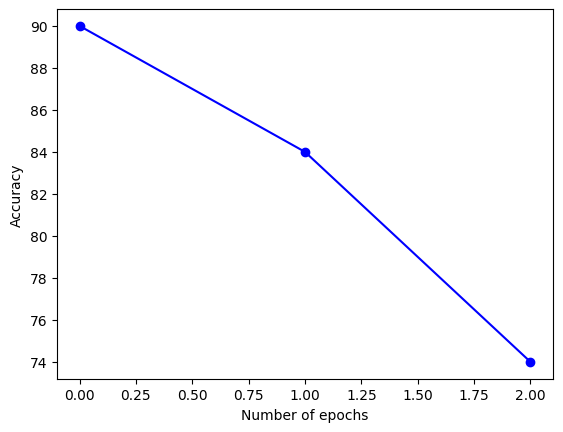

In [26]:
plt.figure()
plt.plot(range(3), total_accuracy, 'b-o');
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")